<a href="https://colab.research.google.com/github/souchem23/data-science-coursework/blob/main/Unit4/SoumikC_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install "preliz[full,notebook]"

In [58]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [59]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [61]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

New Chemical Shift Heirarchial Model (w/ StudentT)

In [64]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu=30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu=30)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 10, nu=30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  nu=μ_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                      nu = 30,
                      sigma = 10,
                      dims = "aa")

    v=pm.HalfStudentT('v', sigma = 10, nu=30, dims="aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = v[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

Normal Chemical Shift Heirarchial Model (w/ Normal)

In [65]:
with pm.Model(coords=aa_coords) as cs_h_model_normal:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h_normal = pm.sample()

Output()

Output()

Ridge Plot Comparison

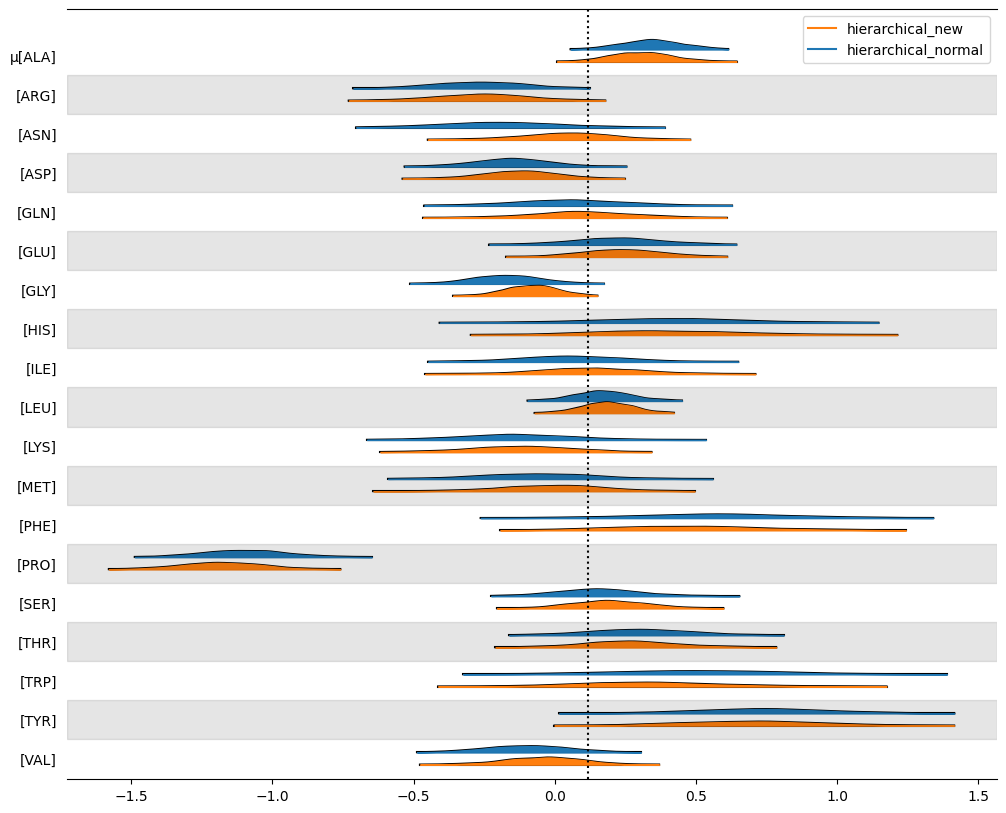

In [66]:
axes = az.plot_forest([idata_cs_h_normal, idata_cs_h], kind="ridgeplot",
                      model_names=['hierarchical_normal', 'hierarchical_new'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Normal Chemical Shift Heirarchial Model (w/ StudentT) Predictive Check

In [67]:
pm.sample_posterior_predictive(idata_cs_h_normal, model=cs_h_model_normal, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

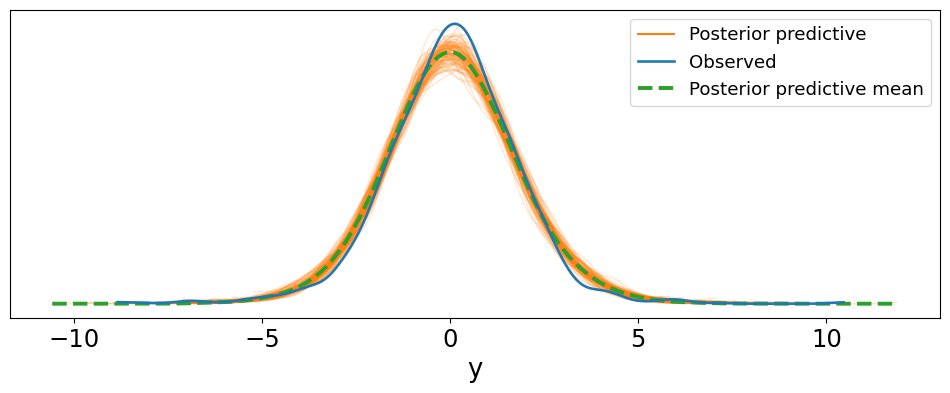

In [72]:
az.plot_ppc(idata_cs_h_normal, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])

New Chemical Shift Heirarchial Model (w/ StudentT) Predictive Check

In [69]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(-15.0, 15.0)

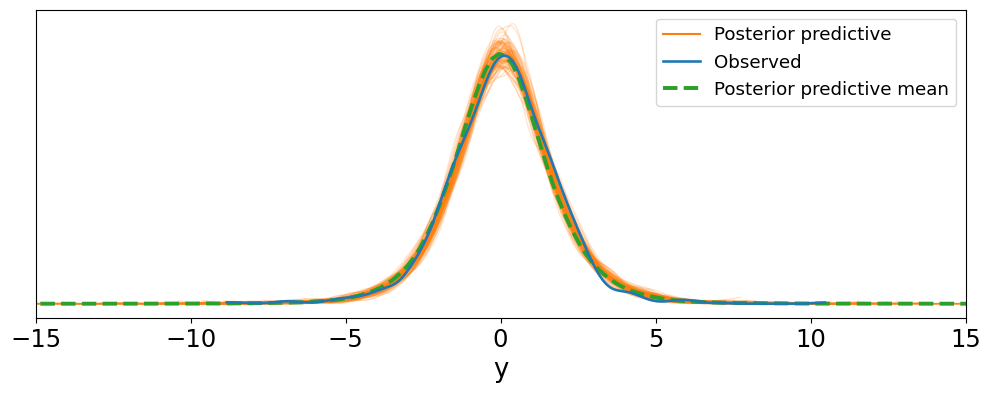

In [71]:
ax=az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
# ax.set_xlim(-5, 5)
ax.set_xlim(-15,15)

Response

The StudentT distribution seems to match the observed data curve much better than the Normal distribution. We can observe that the StudentT model has the same peak as the observed data (matches the mean). The StudentT distribution alsso has a smllaer width, showing that it has a much closer standard deviation. The skew does not match exactly, but it is a lot closer than the Normal distribution model.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [40]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [41]:
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

<Axes: >

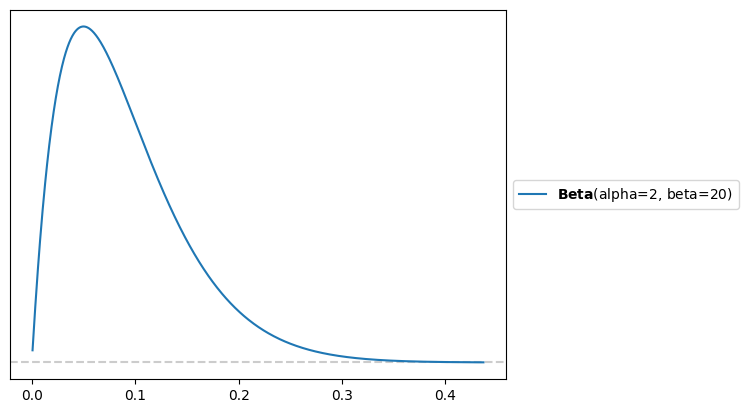

In [42]:
pz.Beta(alpha = 2, beta = 20).plot_pdf()

<Axes: >

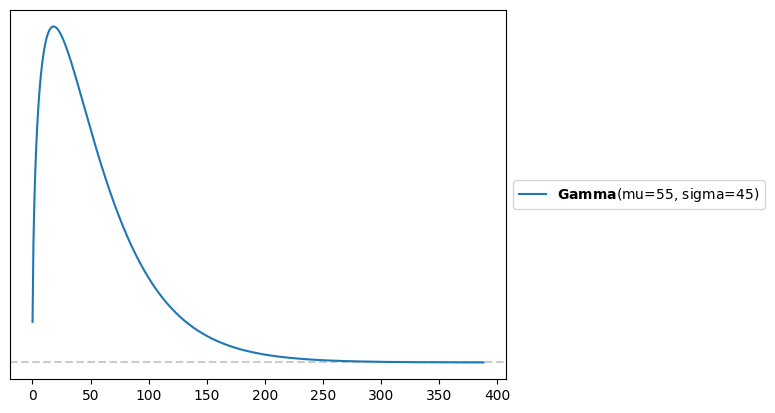

In [43]:
pz.Gamma(mu = 55, sigma = 45).plot_pdf()

In [76]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # No Hyper Paramters since it is non-heirarchial.
    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha=2, beta=20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

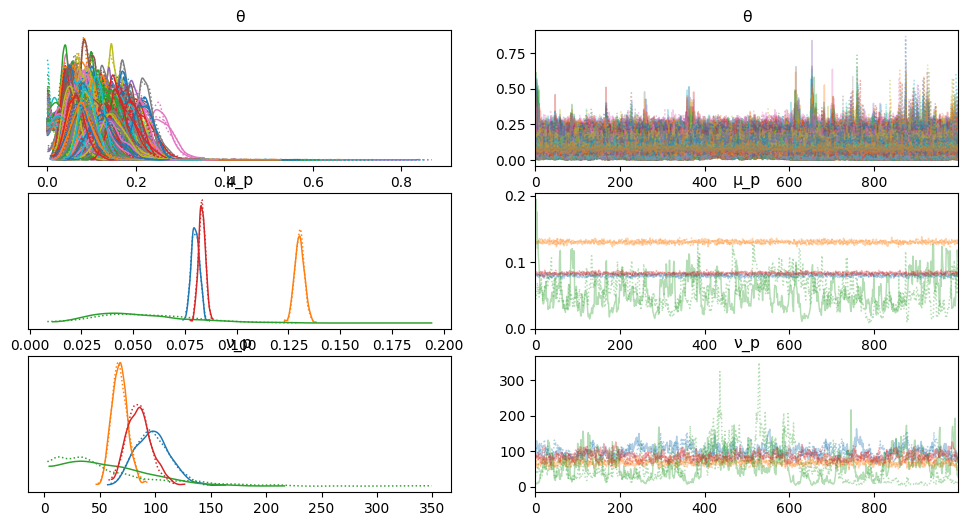

In [77]:
az.plot_trace(idata_sccr)

In [78]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.003 1.001 1.0 ... 1.0 1.0 0.9994 1.002
    μ_p      (pos) float64 32B 1.004 1.001 1.005 1.001
    ν_p      (pos) float64 32B 0.9998 1.009 1.026 1.003

The code above shows the non-heirarchial soccer model. We ran the heirarchial model when working on the in-class notes. This comparison will be based on the answer key provided by Mr. Arredondo.

In comparison to the heirarchial model, we can observe that the "theta" and "μ_p" values are very close.

The theta values in the answer key seem to be very close to 1, with values that are slightly higher and lower. My theta values follow a similar trend, but my highest theta value is 1.003 (greater than the answer key's value of 1.001) while my lowest of 0.9994 matches with the answer key. When looking at the plot_trace graphs, I observe that the theta values for the on-heirarchial model seem to have more tolerance for outliers. It has a larger variance, resulting in values that are slightly farther away from 1.0.

As stated above, the "μ_p" values are also very close to one another. Although the answer key has a "μ_p" value of 1.242, the other values are still very close to one another. When I looked at the plot_trace graphs for the heirarchial model, the peaks of the red and blue were even. Now, however, the red peak has a higher mean (peak) than the blue peak, which also allowed for more variance and frequency of values. The graphs for the "μ_p" and for "v_p" are a lot closer together and seem to have more variance in general.

I also noticed that the "μ_p" for the hierarchial model has a value that is much greater than 1.1. This means that this parameter for the hierarchial model performs worse than the non-hierarchial because it takes into account the GK data which is not as accurate.

I also noticed that the non-heirarchial model has "μ_p", and "v_p" which are more concentrated and has narrower posteriors. The Theta, on the other hand, has much higher variability and is more spread out. This may show that individual players have more uncertainity due to variation in their performance or averages.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

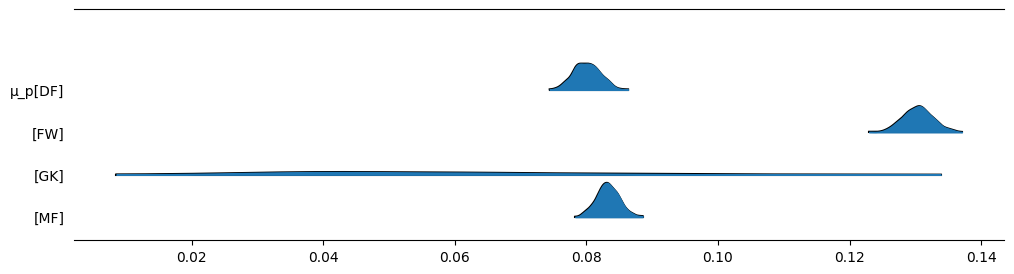

In [79]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posteriors are very similar to the heirarchial model that we did in class. The mean values are rougly around the same values for each of the categories. Specifically, one primary difference is that the GK posterior extends closer to 0.14 than in the heirarchial model.

Another difference is that the GK has less shrinkage so it is wider. The hierarchial model will shrinkage and will not be as wide, as it results in less variance. Thus, the visual above depicts a non-hierarchial model that is not as wide.

For the non goal-keeper positions, the widths and peaks are practically identical to each other. One difference that I noticed is that the non-hierarchial model has posteriors with slightly more negative skew in comparison to the heirarchial model from the notes.


**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [81]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data2 = pd.read_csv(url_sccr)
sccr_data2 = sccr_data2.query('position != "GK"')
# sccr_data_new = pd.DataFrame(sccr_data2[['name','position','goals', 'shots']])
# sccr_data_new.reset_index()

# sccr_data_new = pd.DataFrame(columns=sccr_data2.columns)

# for index, row in sccr_data2.iterrows():
#     if (row['position'] == "GK"):
#       continue
#     sccr_data_new = sccr_data_new._append(row, ignore_index=True)

sccr_data2['position'] = sccr_data2['position'].astype("category")
sccr_data2

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [84]:
pos_idx2 = sccr_data2.position.cat.codes.values
pos_codes2 = sccr_data2.position.cat.categories
sccr_coords2 = {"pos": pos_codes2}

pos_codes2

Index(['DF', 'FW', 'MF'], dtype='object')

In [86]:
with pm.Model(coords = sccr_coords2) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx2], nu = ν_p[pos_idx2])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data2.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data2.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_heirarchial = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

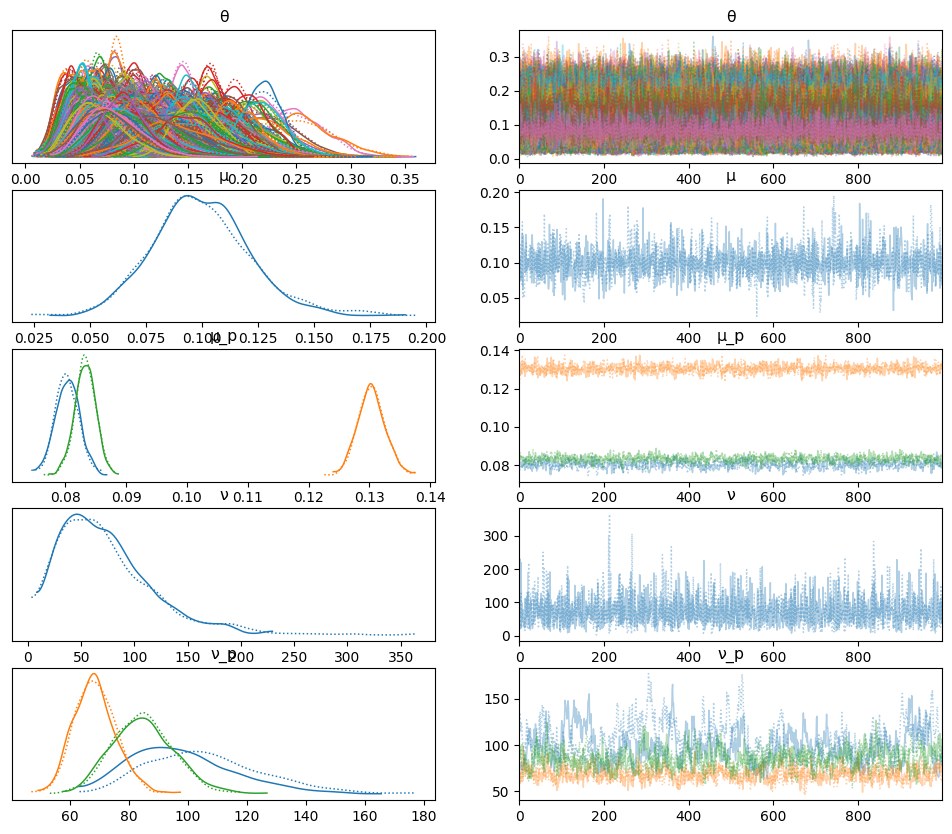

In [87]:
az.plot_trace(idata_sccr_heirarchial)

In [88]:
az.rhat(idata_sccr_heirarchial)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.007 1.002 0.9995 ... 1.0 1.002 1.0
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 0.9999 1.0 1.0
    ν        float64 8B 1.002
    ν_p      (pos) float64 24B 1.049 1.006 1.001

Answer:
1.   I believe that the model I just created (without goal keepers) will be easier for the PYMC to process. Primarily, the model without goal keepers has less data. In general, it will be asier for the model with less data to be processed. Additionally, many goalies have 0 shots and 0 goals, which can make it harder for the model to process. That said, some have actually scored some goals despite the general trend. In general, we are very uncertain about goal keepers in our model because they are unpredictable in their scoring, which adds some complexity to the model. By removing this underlying process, it will be easier for the model to process and handle this uncertainty.
2.   By dropping GK's from the dataset, we are able to improve our processing speed/time since the data is now easier for the PYMC model to process. At the same time, we also gain some consistency as we do not have to deal with the underlying unpredictability that arrives with goal keepers. At the same time, we will lose all the data for the goal keeper category, which will reduce the nuance of the model.

